In [1]:
/pwd

'/content'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from pandas.plotting import parallel_coordinates

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_order = pd.read_csv("/content/order_products__prior.csv")
df_order.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [4]:
df_product = pd.read_csv("/content/products.csv")
df_product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [5]:
df_items = pd.merge(df_order,df_product,how='inner',on='product_id')
df_items.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,26,33120,5,0,Organic Egg Whites,86,16
2,120,33120,13,0,Organic Egg Whites,86,16
3,327,33120,5,1,Organic Egg Whites,86,16
4,390,33120,28,1,Organic Egg Whites,86,16


In [6]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 7 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   order_id           int64 
 1   product_id         int64 
 2   add_to_cart_order  int64 
 3   reordered          int64 
 4   product_name       object
 5   aisle_id           int64 
 6   department_id      int64 
dtypes: int64(6), object(1)
memory usage: 1.9+ GB


In [7]:
df_items = df_items[df_items["reordered"] == 1]
df_items = df_items.head(500000)

# 변경사항 확인
print(df_items["reordered"].value_counts())

1    500000
Name: reordered, dtype: int64


In [8]:
for col in df_items.columns:
    if ("id" in col) & (df_items[col].dtype != "object"):
        df_items[col] = df_items[col].astype(str)

# 변경사항 확인
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 703125
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   order_id           500000 non-null  object
 1   product_id         500000 non-null  object
 2   add_to_cart_order  500000 non-null  int64 
 3   reordered          500000 non-null  int64 
 4   product_name       500000 non-null  object
 5   aisle_id           500000 non-null  object
 6   department_id      500000 non-null  object
dtypes: int64(2), object(5)
memory usage: 30.5+ MB


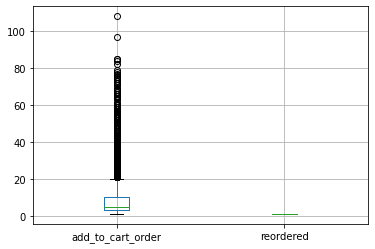

In [9]:
df_items.boxplot();

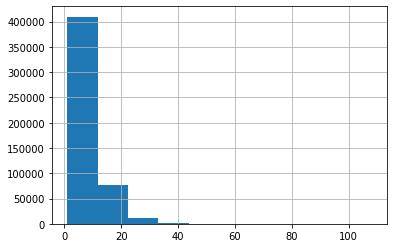

In [10]:
#  일반적으로 함께 구매하는 품목의 수를 확인
df_items["add_to_cart_order"].hist();

In [11]:
df_items.describe().T

,count,mean,std,min,25%,50%,75%,max
add_to_cart_order,500000.000,7.017,6.064,1.000,3.000,5.000,10.000,108.000
reordered,500000.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000


In [12]:
df_items.describe(include = 'O').T

,count,unique,top,freq
order_id,500000,436676,4,12
product_id,500000,31,21903,186884
product_name,500000,31,Organic Baby Spinach,186884
aisle_id,500000,22,123,188248
department_id,500000,9,4,368042


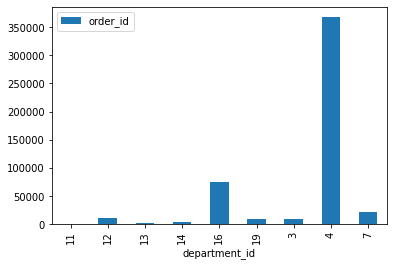

In [13]:
# 매출의 대부분이 발생하는 부서를 확인인
df_items[["order_id", "department_id"]].groupby("department_id").count().plot(kind = "bar");

In [14]:
df = df_items[['order_id','product_name']].copy()
df.rename(columns={'order_id':'order','product_name':'items'},inplace=True)
df['marker']=1

In [15]:
df.head()

,order,items,marker
0,2,Organic Egg Whites,1
3,327,Organic Egg Whites,1
4,390,Organic Egg Whites,1
5,537,Organic Egg Whites,1
6,582,Organic Egg Whites,1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 703125
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   order   500000 non-null  object
 1   items   500000 non-null  object
 2   marker  500000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.3+ MB


In [17]:
def make_matrix(df):
        return df.groupby(['order','items'])['marker'].sum().unstack().fillna(0). \
            applymap(lambda x: 1 if x > 0 else 0)

In [18]:
df_matrix = make_matrix(df)

In [19]:
freq_itemsets = apriori(df_matrix, min_support=0.01, use_colnames=True)

# 데이터 프레임에서 유추한 규칙칙
rules = association_rules(freq_itemsets,metric='support',min_threshold=0.01)
rules.sort_values('support',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(Michigan Organic Kale),(Organic Baby Spinach),0.107,0.428,0.021,0.196,0.457,-0.025,0.711
5,(Organic Baby Spinach),(Michigan Organic Kale),0.428,0.107,0.021,0.049,0.457,-0.025,0.939
2,(Carrots),(Organic Baby Spinach),0.107,0.428,0.017,0.160,0.373,-0.029,0.681
3,(Organic Baby Spinach),(Carrots),0.428,0.107,0.017,0.040,0.373,-0.029,0.930
0,(Bag of Organic Bananas),(Organic Baby Spinach),0.129,0.428,0.015,0.118,0.277,-0.040,0.649
1,(Organic Baby Spinach),(Bag of Organic Bananas),0.428,0.129,0.015,0.036,0.277,-0.040,0.903
6,(Organic Ginger Root),(Organic Baby Spinach),0.068,0.428,0.014,0.200,0.468,-0.016,0.715
7,(Organic Baby Spinach),(Organic Ginger Root),0.428,0.068,0.014,0.032,0.468,-0.016,0.962
8,(Unsweetened Almondmilk),(Organic Baby Spinach),0.086,0.428,0.011,0.129,0.301,-0.026,0.657
9,(Organic Baby Spinach),(Unsweetened Almondmilk),0.428,0.086,0.011,0.026,0.301,-0.026,0.939


In [20]:
# 데이터프레임을 lift별로 정렬렬
rules.sort_values("lift", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6,(Organic Ginger Root),(Organic Baby Spinach),0.068,0.428,0.014,0.200,0.468,-0.016,0.715
7,(Organic Baby Spinach),(Organic Ginger Root),0.428,0.068,0.014,0.032,0.468,-0.016,0.962
4,(Michigan Organic Kale),(Organic Baby Spinach),0.107,0.428,0.021,0.196,0.457,-0.025,0.711
5,(Organic Baby Spinach),(Michigan Organic Kale),0.428,0.107,0.021,0.049,0.457,-0.025,0.939
2,(Carrots),(Organic Baby Spinach),0.107,0.428,0.017,0.160,0.373,-0.029,0.681
3,(Organic Baby Spinach),(Carrots),0.428,0.107,0.017,0.040,0.373,-0.029,0.930
8,(Unsweetened Almondmilk),(Organic Baby Spinach),0.086,0.428,0.011,0.129,0.301,-0.026,0.657
9,(Organic Baby Spinach),(Unsweetened Almondmilk),0.428,0.086,0.011,0.026,0.301,-0.026,0.939
1,(Organic Baby Spinach),(Bag of Organic Bananas),0.428,0.129,0.015,0.036,0.277,-0.040,0.903
0,(Bag of Organic Bananas),(Organic Baby Spinach),0.129,0.428,0.015,0.118,0.277,-0.040,0.649


In [21]:
# 지정된 항목 집합에 대하여 다른규칙을 추가가
filtered_rules = rules[(rules['antecedent support'] > 0.02)&
                        (rules['consequent support'] >0.01) &
                        (rules['confidence'] > 0.45) &
                        (rules['lift'] > 1.0)&
                        (rules['support']>0.195)]

In [23]:
def rules_to_coordinates(rules):
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent:list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent:list(consequent)[0])
    rules['rule'] = rules.index
    return rules[['antecedent','consequent','rule']]

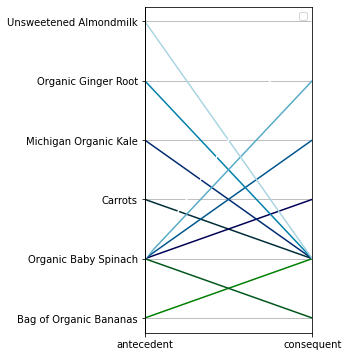

In [24]:
# 평면 좌표도에 사용하기 적합한 좌표로 변환환
coords = rules_to_coordinates(rules)
# 평행 좌표도 생성
plt.figure(figsize=(3,6))
parallel_coordinates(coords, 'rule',colormap = 'ocean')
plt.legend([])
plt.show()

In [25]:
def check_product(item, df =df):
    product_name = df[df["items"] == item]["items"].unique()[0]
    return product_name

In [26]:
def recommend_product(item, df = df, qty = 5):
    products = item
    code_list = []
    name_list = []
    sorted_rules = rules.sort_values("lift", ascending=False)
    for idx, product in enumerate(sorted_rules["antecedents"]):
        for j in list(product):
            if j == products:
                code_list.append(list(sorted_rules.iloc[idx]["consequents"])[0])
                code_list = list(dict.fromkeys(code_list))
                
      # df의 제품명을 출력력
    if len(code_list) <= 0:
        return "Invalid Product, try again!"
    else:
        for code in code_list:
            name_list.append(check_product(code))
    
    
    print(f"Recommended product(s) for {item} is/are:")
    for i, item in enumerate(name_list):
        print(i+1, item)

In [27]:
 recommend_product("Organic Baby Spinach")

Recommended product(s) for Organic Baby Spinach is/are:
1 Organic Ginger Root
2 Michigan Organic Kale
3 Carrots
4 Unsweetened Almondmilk
5 Bag of Organic Bananas
